In [1]:
import os
import json
import re
from time import time
from itertools import product

import numpy as np
import torch
from torch import optim
from torch import nn
from torch.autograd import Variable
from torch.nn import Softmax
import matplotlib.pyplot as plt
%matplotlib inline

from datautils.dataset import Alphabet, to_categorical, SentenceDataset, Dataset
from models.utils import RNN_Hyperparameters
from models.rnn import get_rnn_for_hyperparams

from training import evaluate_rnn, evaluate_rnn_sentences

In [2]:
use_gpu = True

exp_dir = '../rnn-experiment-storage/22_en_60_b250_lstm_1024/'

model_id = '0'

alphabet = Alphabet.from_json(os.path.join(exp_dir, 'alphabet.json'))

results_file = os.path.join(exp_dir, 'out/results.json')
with open(results_file, 'r') as fp:
    exp_results = json.load(fp)

hyperparams = RNN_Hyperparameters(**exp_results[str(model_id)]['config'])

model = get_rnn_for_hyperparams(hyperparams, alphabet.get_size(), use_gpu)

checkpoint_path = exp_results[str(model_id)]['path']

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

if use_gpu:
    model.cuda()

In [3]:
import pandas as pd
hidden_states_folder = os.path.join(exp_dir, 'out', model_id, 'init_hiddens')

df = None

for fold in os.listdir(hidden_states_folder):
    with open(os.path.join(hidden_states_folder, fold, 'stats.json'), 'r') as fp:
        stats = json.load(fp)
        stats['min_val_loss'] = min(stats['valid_losses'])
        stats['init_val_loss'] = stats['valid_losses'][0]

    with open(os.path.join(hidden_states_folder, fold, 'stats.json'), 'w') as fp:
        json.dump(stats, fp, indent=2)

    del stats['train_losses']
    del stats['valid_losses']
    stats['id'] = fold
    if df is None:
        df = pd.DataFrame(stats)
    else:
        df = df.append(pd.DataFrame(stats))
    

In [18]:
df = df.sort_values(by=['num_timesteps', 'min_val_loss'])
display(df)

dft = df.groupby(['num_timesteps']).head(1)
dft = dft[['num_timesteps', 'min_val_loss', 'init_val_loss']]
dft = dft.rename(columns={'num_timesteps': 'Sequence length', 'min_val_loss': 'Best validation loss',
             'init_val_loss': 'Default validation loss'})
print(dft.T.round(2).to_latex(index_names=False, index=True))

,batch_size,num_timesteps,lr,epochs,train_files_list,valid_files_list,min_val_loss,init_val_loss,id
0,10,5,0.3,10,datasets/es-en/en/train.txt,datasets/es-en/en/valid.txt,2.098500,4.847192,1
0,10,5,0.1,10,datasets/es-en/en/train.txt,datasets/es-en/en/valid.txt,2.102540,4.847192,0
0,100,5,0.9,10,datasets/es-en/en/train.txt,datasets/es-en/en/valid.txt,2.177338,4.847192,11
0,100,5,0.3,10,datasets/es-en/en/train.txt,datasets/es-en/en/valid.txt,2.269687,4.847192,10
0,100,5,0.1,10,datasets/es-en/en/train.txt,datasets/es-en/en/valid.txt,2.355624,4.847192,9
0,10,5,0.9,10,datasets/es-en/en/train.txt,datasets/es-en/en/valid.txt,4.847192,4.847192,2
0,10,10,0.3,10,datasets/es-en/en/train.txt,datasets/es-en/en/valid.txt,1.583148,3.101713,4
0,10,10,0.1,10,datasets/es-en/en/train.txt,datasets/es-en/en/valid.txt,1.586567,3.101713,3
0,100,10,0.9,10,datasets/es-en/en/train.txt,datasets/es-en/en/valid.txt,1.651159,3.101713,14
0,100,10,0.3,10,datasets/es-en/en/train.txt,datasets/es-en/en/valid.txt,1.707644,3.101713,13


\begin{tabular}{lrrr}
\toprule
{} &     0 &      0 &      0 \\
\midrule
Sequence length         &  5.00 &  10.00 &  20.00 \\
Best validation loss    &  2.10 &   1.58 &   1.41 \\
Default validation loss &  4.85 &   3.10 &   2.24 \\
\bottomrule
\end{tabular}



In [16]:
dft.T

,0,0,0
Sequence length,5.000000,10.000000,20.000000
Best validation loss,2.098500,1.583148,1.413729
Default validation loss,4.847192,3.101713,2.237097


# How much does a good hidden state decrease the loss on the whole dataset

In [89]:
%%time

init_state_id = '6'
h = np.load(os.path.join(hidden_states_folder, init_state_id, 'h.npy'))
c = np.load(os.path.join(hidden_states_folder, init_state_id, 'c.npy'))

init_hidden = (Variable(torch.Tensor(h)), Variable(torch.Tensor(c)))

if use_gpu:
    init_hidden = (init_hidden[0].cuda(), init_hidden[1].cuda())

test_file = 'datasets/es-en/en/test.txt'
test_data = Dataset(test_file, alphabet)

loss_function = nn.modules.loss.CrossEntropyLoss()
num_timesteps = 30

stats = {}
for dynamic in (False, True):
    stats[dynamic] = dict()
    for use_init in True, False:
        model.load_state_dict(checkpoint['state_dict'])
        ih = init_hidden if use_init else None
        _, loss = evaluate_rnn(model, test_data, loss_function, num_timesteps, use_gpu, dynamic=dynamic, learning_rate=0.3,
                               initial_hidden=ih, record_stats=False, stats_interval=num_timesteps)
        stats[dynamic][use_init] = ss
        print(dynamic, use_init, loss)

KeyboardInterrupt: 

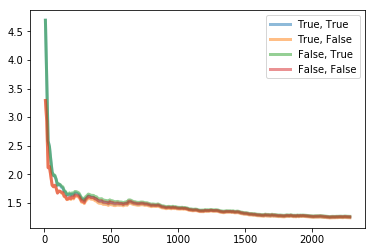

In [71]:
for dynamic in True, False:
    for use_init in True, False:
        ss = stats[dynamic][use_init]
        plt.plot(ss['chars_processed'], ss['loss'], label=f'{dynamic}, {use_init}', alpha=0.5, lw=3)
plt.legend()

In [78]:
init_hidden

(Variable containing:
 ( 0  ,.,.) = 
   4.0742e-05 -2.1260e-03 -9.6314e-04  ...  -3.8516e-09 -1.1363e-09 -2.3503e-05
 [torch.cuda.FloatTensor of size 1x1x1024 (GPU 0)], Variable containing:
 ( 0  ,.,.) = 
   2.2716e-02 -3.1635e-03 -3.5629e-02  ...  -3.9950e-04 -2.0459e-05 -1.4536e-02
 [torch.cuda.FloatTensor of size 1x1x1024 (GPU 0)])

In [84]:
import copy
LOG_2E = np.log2(np.e)
def evaluate_rnn_sentences(model, valid_data, initial_hidden, batch_size, num_timesteps, pad_input, loss_function,
                       use_gpu, max_chars=np.inf, dynamic=False, learning_rate=0.1, decay_coef=0):
    tot_val_loss = 0
    val_chars_processed = 0
    val_loss_history = []

    if dynamic:
        original_weigths = [copy.deepcopy(p.data) for p in model.parameters()]

    for inputs, targets in valid_data.get_batch_iterator(batch_size=1, num_timesteps=num_timesteps,
                                                         pad_input=pad_input, max_chars_per_file=max_chars):
        model.hidden = (Variable(initial_hidden[0].data.mean(1).view(model.num_layers, 1, model.hidden_dim)),
                        Variable(initial_hidden[1].data.mean(1).view(model.num_layers, 1, model.hidden_dim)))

        if use_gpu:
            inputs = Variable(torch.Tensor(inputs)).cuda()
            targets = Variable(torch.LongTensor(targets)).cuda()
        else:
            inputs = Variable(torch.Tensor(inputs))
            targets = Variable(torch.LongTensor(targets))

        # Forward pass through a batch of sequences - the result is <batch_size x num_timesteps x alphabet_size> -
        # the outputs for each sequence in the batch, at every timestep in the sequence
        logits = model(inputs)

        loss = loss_function(logits.contiguous().view(-1, logits.data.shape[-1]), targets.contiguous().view(-1))

        if dynamic:
            # Backward pass - compute gradients, propagate gradient information back through the network
            loss.backward()

            # SGD with global prior update
            for p, o in zip(model.parameters(), original_weigths):
                p.data += - learning_rate * p.grad.data + decay_coef * (o - p.data)

        val_loss_history.append(loss.data[0])
        tot_val_loss += loss.data[0] * inputs.shape[1]
        val_chars_processed += inputs.shape[1]

    val_loss = tot_val_loss / val_chars_processed
    return LOG_2E * val_loss, val_loss_history

In [86]:
%%time

init_state_id = '6'
h = np.load(os.path.join(hidden_states_folder, init_state_id, 'h.npy'))
c = np.load(os.path.join(hidden_states_folder, init_state_id, 'c.npy'))

init_hidden = (Variable(torch.Tensor(h)), Variable(torch.Tensor(c)))

if use_gpu:
    init_hidden = (init_hidden[0].cuda(), init_hidden[1].cuda())

test_file = 'datasets/en_test.txt'
test_data = SentenceDataset([test_file], alphabet)

loss_function = nn.modules.loss.CrossEntropyLoss()
num_timesteps = 10

stats = {}
for dynamic in (False, True):
    stats[dynamic] = dict()
    for use_init in True, False:
        model.load_state_dict(checkpoint['state_dict'])
        ih = init_hidden if use_init else model.init_hidden()
        _, losses = evaluate_rnn_sentences(model, test_data, initial_hidden=ih, batch_size=1,
                                             num_timesteps=num_timesteps, loss_function=loss_function,
                                             pad_input=True, use_gpu=True, dynamic=dynamic, learning_rate=0.3)
        stats[dynamic][use_init] = losses
        print(dynamic, use_init, min(losses))

False True 2.7232699394226074
False False 1.773155927658081
True True 0.3498876988887787
True False 0.20157508552074432
Wall time: 1.54 s
